The purpose of this notebook is to check how many tokens we need for optimal language classification

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import gc
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)


raw_dir = "/home/peterr/macocu/taskB/data/raw"
interim_dir = "/home/peterr/macocu/taskB/data/interim"
final_dir = "/home/peterr/macocu/taskB/data/final"

In [2]:
import parse
from typing import List


def get_N_tokens(N=5000, path="/home/peterr/macocu/taskB/task4/toy_tokens.csv") -> set:

    df = pd.read_csv("toy_tokens.csv", index_col=0)
    NUM_FEATS = N

    for column in df.columns:
        new_column_name = column + "_f"
        corpus_size = df[column].sum()
        df[new_column_name] = df[column] * 1e6 / corpus_size

    N = 1

    df["HR_SR"] = (df["hrwac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_HR"] = (df["srwac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["HR_CNR"] = (df["hrwac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_HR"] = (df["cnrwac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["HR_BS"] = (df["hrwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)
    df["BS_HR"] = (df["bswac_head_pp_f"] + N) / (df["hrwac_head_pp_f"] + N)

    df["BS_SR"] = (df["bswac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_BS"] = (df["srwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)

    df["BS_CNR"] = (df["bswac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)
    df["CNR_BS"] = (df["cnrwac_head_pp_f"] + N) / (df["bswac_head_pp_f"] + N)

    df["CNR_SR"] = (df["cnrwac_head_pp_f"] + N) / (df["srwac_head_pp_f"] + N)
    df["SR_CNR"] = (df["srwac_head_pp_f"] + N) / (df["cnrwac_head_pp_f"] + N)

    combos = ['HR_SR', 'SR_HR', 'HR_CNR', 'CNR_HR', 'HR_BS', 'BS_HR',
              'BS_SR', 'SR_BS', 'BS_CNR', 'CNR_BS', 'CNR_SR', 'SR_CNR']

    important_features = set()

    for lang_comb in combos:
        s = df.sort_values(lang_comb, ascending=False)[lang_comb]
        current_features = s.index[:NUM_FEATS].values
        important_features = important_features.union(set(current_features))
    try:
        important_features.remove(np.nan)
    except KeyError:
        pass
    return important_features


def read_and_split_file(path: str) -> List[str]:
    texts = list()
    chunk = ""
    with open(path, "r") as f:
        content = f.readlines()
    for line in content:
        # Handle splits
        if line == "\n":
            texts.append(chunk)
            chunk = ""
        # Filter only lowercase alphabetical words:
        from utils import is_alpha
        line = line.replace("\n", " ")
        words = [w if is_alpha(w) else " " for w in line.split(" ")]
        chunk += " ".join(words)
    return texts


texts, labels = list(), list()

files = [
    "bswac_tail_pp",
    "cnrwac_tail_pp",
    "hrwac_tail_pp",
    "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang]*len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})

del texts, labels

SETimes = list()
for split in ["train", "test", "dev"]:
    with open(os.path.join(final_dir, f"{split}.fasttxt"), "r") as f:
        lines = f.readlines()
        SETimes.extend(lines)

p = parse.compile("__label__{lang} {text}")
langs = list()
texts = list()

for line in SETimes:
    results = p.parse(line)
    if not results:
        logging.error(f"Error parsing line {line}")
        continue
    langs.append(results["lang"])
    texts.append(results["text"])

eval_df = pd.DataFrame(data={"text": texts, "labels": langs})

del texts, langs, SETimes, line, lines, p


def get_stats(N: int):
    import gc
    import time
    from sklearn.naive_bayes import GaussianNB
    from sklearn.feature_extraction.text import CountVectorizer
    gc.collect()
    start = time.time()
    vectorizer = CountVectorizer(
        vocabulary=get_N_tokens(N), lowercase=True, binary=True)

    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels

    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels

    clf = GaussianNB()
    train_start = time.time()
    clf.fit(train_vectors.toarray(), train_labels)
    predict_start = time.time()
    y_pred = clf.predict(test_vectors.toarray())
    predict_end = time.time()
    from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
    LABELS = ["hr", "bs", "sr",  "me"]
    LABELS = ["hr", "bs", "sr",  "me"]

    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    return {
        "N": N,
        "microF1": micro,
        "macroF1": macro,
        "accuracy": acc,
        "overall_time": time.time() - start,
        "cm": cm,
        "vectorizer_fitting": train_start - start,
        "training_time": predict_start - train_start,
        "predicting_time": predict_end - predict_start
    }


In [23]:
results_old = results
results = list()
Ns = np.logspace(2.5, 4, 15, dtype=np.int)
for N in Ns:
    try:
        gc.collect()
        logging.info(f"{N=}")
        cur_result = get_stats(N)
        logging.info(f"Done!")
        results.append(cur_result)
    except Exception as e:
        logging.error(f"For {N=} got Exception: {e}")
results = results_old + results

2022-01-03 14:27:51,456 - N=316
2022-01-03 14:28:57,530 - Done!
2022-01-03 14:28:57,586 - N=404
2022-01-03 14:30:06,195 - Done!
2022-01-03 14:30:06,251 - N=517
2022-01-03 14:31:19,591 - Done!
2022-01-03 14:31:19,647 - N=662
2022-01-03 14:32:38,275 - Done!
2022-01-03 14:32:38,335 - N=848
2022-01-03 14:34:03,627 - Done!
2022-01-03 14:34:03,683 - N=1085
2022-01-03 14:35:35,662 - Done!
2022-01-03 14:35:35,721 - N=1389
2022-01-03 14:37:18,471 - Done!
2022-01-03 14:37:18,528 - N=1778
2022-01-03 14:39:11,247 - Done!
2022-01-03 14:39:11,303 - N=2275
2022-01-03 14:41:15,069 - Done!
2022-01-03 14:41:15,127 - N=2912
2022-01-03 14:43:35,201 - Done!
2022-01-03 14:43:35,257 - N=3727
2022-01-03 14:46:16,187 - Done!
2022-01-03 14:46:16,243 - N=4770
2022-01-03 14:49:22,787 - Done!
2022-01-03 14:49:22,842 - N=6105
2022-01-03 14:53:13,822 - Done!
2022-01-03 14:53:13,885 - N=7813
2022-01-03 14:54:41,429 - For N=7813 got Exception: Unable to allocate 98.0 GiB for an array with shape (343841, 38256) and dat

In [28]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.tail()


,microF1,macroF1,accuracy,overall_time,cm,vectorizer_fitting,training_time,predicting_time
N,,,,,,,,
3162,0.842839,0.641097,0.842839,151.341194,"[[2216, 969, 0, 11], [93, 2949, 32, 121], [2, ...",52.288276,94.433539,4.559651
3727,0.838734,0.637555,0.838734,160.881018,"[[2165, 1020, 0, 11], [88, 2967, 28, 112], [3,...",52.270960,103.571598,4.979475
4770,0.826312,0.629034,0.826312,186.494760,"[[2077, 1106, 0, 13], [96, 2934, 34, 131], [4,...",52.806347,127.531613,6.096651
5179,0.823180,0.626978,0.823180,200.350301,"[[2061, 1121, 0, 14], [98, 2923, 38, 136], [2,...",53.694116,139.736826,6.861143
6105,0.813891,0.620318,0.813891,230.929277,"[[1998, 1181, 0, 17], [105, 2911, 39, 140], [1...",53.294457,169.956798,7.617250


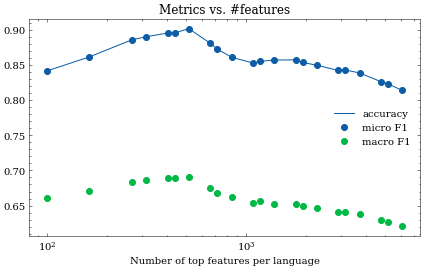

In [37]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.title("Metrics vs. #features")
plt.xlabel("Number of top features per language")
plt.semilogx()
plt.savefig("images/14_metrics.png")
plt.show()

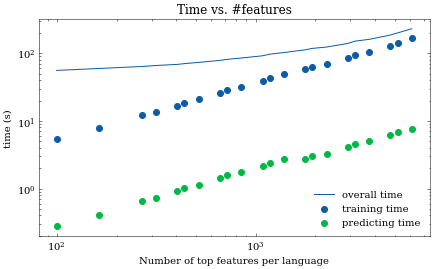

In [36]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["training_time"],label="training time")

plt.scatter(rezdf.index, rezdf["predicting_time"],label="predicting time")

plt.plot(rezdf.index, rezdf["overall_time"],label="overall time")
plt.legend()
plt.title("Time vs. #features")
plt.xlabel("Number of top features per language")
plt.ylabel("time (s)")
plt.semilogx()
plt.semilogy()
plt.savefig("images/14_time.png")
plt.show()

In [38]:
rezdf.to_csv("14_results_SETimes.csv", index=False)

## Repeating the experiment with evaluation on Twitter data

Evaluation dataset will be overwritten with twitter dataset and the experiment will be rerun.

In [39]:
import pickle

with open("/home/peterr/macocu/taskB/data/final/twitter_full_ds.pickle", "rb") as f:
    twitter_ds = pickle.load(f)

users = twitter_ds.keys()
languages = [twitter_ds[user]["language"] for user in users]
tweets = [" ".join(twitter_ds[user]["tweets"]) for user in users]

eval_df = pd.DataFrame(data={"text": tweets, "labels": languages})

del users, languages, tweets, twitter_ds


results_tw = list()
Ns = np.logspace(2, 4, 15, dtype=np.int)
for N in Ns:
    try:
        gc.collect()
        logging.info(f"{N=}")
        cur_result = get_stats(N)
        logging.info(f"Done!")
        results_tw.append(cur_result)
    except Exception as e:
        logging.error(f"For {N=} got Exception: {e}")


2022-01-03 15:29:09,464 - N=100
2022-01-03 15:30:03,092 - Done!
2022-01-03 15:30:03,148 - N=138
2022-01-03 15:30:58,609 - Done!
2022-01-03 15:30:58,664 - N=193


In [ ]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.tail()

In [ ]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.legend()
plt.title("Metrics vs. #features on Twitter DS")
plt.xlabel("Number of top features per language")
plt.semilogx()
plt.savefig("images/14_metrics_twitter.png")
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["training_time"],label="training time")

plt.scatter(rezdf.index, rezdf["predicting_time"],label="predicting time")

plt.plot(rezdf.index, rezdf["overall_time"],label="overall time")
plt.legend()
plt.title("Time vs. #features on Twitter DS")
plt.xlabel("Number of top features per language")
plt.ylabel("time (s)")
plt.semilogx()
plt.semilogy()
plt.savefig("images/14_time_twitter.png")
plt.show()

rezdf.to_csv("14_results_twitter.csv", index=False)